# Model Comparison

In this notebook, all the models that were optimized in previous notebooks would be evaluated and compared with each other. The mean absolute error and quantile loss is selected as the loss error function. The models will be evaluated using R2, MAE and MSE loss metric based on the same 20% test set.

In [1]:
### PACKAGES IMPORTS ###
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import lightgbm as lgb
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tcn import TCN
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from scipy.integrate import simps
from scipy import stats

### INCLUDE GRAPHS IN NOTEBOOK AUTOMATICALLY ###
%matplotlib inline 

## Import Data

In [2]:
#load csv file
raw_data = pd.read_csv('C:/Users/nghj7/Desktop/Flight data/filtered_data.csv');
#create dataframe
df = pd.DataFrame(raw_data);
print('Shape of dataframe: ', df.shape)
df

Shape of dataframe:  (6832, 24)


,time,flight,drone_type,v_N,v_E,v_D,a_N,a_E,a_D,wind_N,...,long,lat,phi,theta,psi,angular_x,angular_y,angular_z,wind_speed,wind_angle
0,0.000,1,matrice_100,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.0,...,-79.782396,40.458047,0.000560,0.009941,-0.516789,0.000000,0.000000,0.000000,0.0,0.0
1,0.810,1,matrice_100,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.0,...,-79.782396,40.458047,0.000561,0.009950,-0.516782,0.000000,0.000000,0.000000,0.0,0.0
2,1.500,1,matrice_100,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.0,...,-79.782397,40.458047,0.000571,0.009934,-0.516757,0.000000,0.000000,0.000000,0.0,0.0
3,2.300,1,matrice_100,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.0,...,-79.782397,40.458047,0.000576,0.009938,-0.516745,0.000000,0.000000,0.000000,0.0,0.0
4,3.000,1,matrice_100,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.0,...,-79.782397,40.458048,0.000587,0.009939,-0.516732,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6827,445.858,501,inspire,-0.016295,-0.047314,0.923826,0.005702,-0.013041,-1.065106,0.0,...,103.683285,1.344939,1.523057,-0.082441,-151.844488,8.974604,-5.662300,-3.522902,0.0,0.0
6828,446.858,501,inspire,0.025509,-0.027040,0.356245,-0.002888,-0.006615,-1.101281,0.0,...,103.683285,1.344939,0.956871,-0.789295,-155.280442,-1.846924,0.216854,-3.134087,0.0,0.0
6829,447.858,501,inspire,0.039037,-0.101185,0.012075,0.004992,-0.002673,-1.033789,0.0,...,103.683284,1.344938,0.323613,1.214056,-151.855352,-0.667574,-1.356790,10.510001,0.0,0.0
6830,448.858,501,inspire,0.003986,-0.048694,0.073468,0.005926,-0.002943,-1.054360,0.0,...,103.683283,1.344938,-0.770386,0.245185,-149.771986,20.306923,4.552239,-0.612599,0.0,0.0


## Model Variables

In [3]:
features =  ['v_N','v_E','v_D',
             'a_N','a_E','a_D',
             'wind_N', 'wind_E',
             'total_mass']
labels = ['battery_power']

## Model Hyperparameters

In [4]:
#mean square error
param_list = {
    'gbt':  {'objective': 'regression_l1', 'metric': 'l1', 'n_estimators': 576, 'max_depth': 8, 'learning_rate': 0.13821252693438402, 'min_split_gain': 0.25459583548539483, 'subsample': 0.1, 'colsample_bytree': 0.9, 'colsample_bynode': 0.5, 'reg_alpha': 6.220153372834579, 'reg_lambda': 66.59646681393095, 'num_leaves': 39},
    'mlp':  {'loss': tf.keras.losses.MeanAbsoluteError(), 'metric':  tf.keras.metrics.MeanAbsoluteError(), 'monitor': 'val_mean_absolute_error', 'n_layers': 2, 'reg_alpha': 0.0005131571939620729, 'reg_lambda': 4.907168140008659e-05, 'dropout_rate': 0.15744324870969417, 'n_units_0': 64, 'n_units_1': 128, 'learning_rate': 0.005151833969665437, 'eta_decay': 0.7156563191955507},
    'lstm': {'loss': tf.keras.losses.MeanAbsoluteError(), 'metric':  tf.keras.metrics.MeanAbsoluteError(), 'monitor': 'val_mean_absolute_error', 'time_step': 15, 'n_layers': 3, 'reg_alpha': 2.707930829352742e-05, 'reg_lambda': 0.0005186433920784211, 'n_units_0': 16, 'n_units_1': 32, 'n_units_2': 32, 'learning_rate': 0.009088836922769766, 'eta_decay': 0.5684373491704359},
    'tcn':  {'loss': tf.keras.losses.MeanAbsoluteError(), 'metric':  tf.keras.metrics.MeanAbsoluteError(), 'monitor': 'val_mean_absolute_error', 'time_step': 27, 'n_layers': 3, 'kernel_size': 2, 'filter_size': 32, 'learning_rate': 0.0012804854392564095, 'eta_decay': 0.7095021617488534}
}
#quantile
param_list2 = {
    'gbt_0.1':  {'objective': 'quantile', 'metric': 'quantile', 'alpha':0.1, 'n_estimators': 661, 'max_depth': 8, 'learning_rate': 0.12834399886835557, 'min_split_gain': 0.20467965670020832, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.6, 'colsample_bynode': 0.6, 'reg_alpha': 0.2407676020352767, 'reg_lambda': 84.91630578159659, 'num_leaves': 50},
    'gbt_0.5': {'objective': 'quantile', 'metric': 'quantile', 'alpha':0.5, 'n_estimators': 771, 'max_depth': 8, 'learning_rate': 0.02367604576762239, 'min_split_gain': 0.537718730015741, 'subsample': 0.5, 'colsample_bytree': 0.7000000000000001, 'colsample_bynode': 0.30000000000000004, 'reg_alpha': 0.1670941366297709, 'reg_lambda': 81.44508493673695, 'num_leaves': 150},
    'gbt_0.9': {'objective': 'quantile', 'metric': 'quantile', 'alpha': 0.9, 'n_estimators': 626, 'max_depth': 7, 'learning_rate': 0.09724092433454179, 'min_split_gain': 0.1376198605283893, 'subsample': 0.8, 'colsample_bytree': 0.7000000000000001, 'colsample_bynode': 0.6, 'reg_alpha': 0.05502863624044846, 'reg_lambda': 42.62626004560948, 'num_leaves': 38},
    'mlp_0.1': {'loss': tfa.losses.PinballLoss(tau = 0.1, name = 'quantile'), 'metric': tfa.losses.PinballLoss(tau = 0.1, name = 'quantile', reduction = tf.keras.losses.Reduction.NONE), 'monitor': 'val_quantile','n_layers': 3, 'reg_alpha': 6.212514791077957e-06, 'reg_lambda': 2.326652392916294e-06, 'dropout_rate': 0.10456554658254263, 'n_units_0': 256, 'n_units_1': 128, 'n_units_2': 32, 'learning_rate': 0.0219363399910911, 'eta_decay': 0.8507050517321648},
    'mlp_0.5':  {'loss': tfa.losses.PinballLoss(tau = 0.5, name = 'quantile'), 'metric': tfa.losses.PinballLoss(tau = 0.5, name = 'quantile', reduction = tf.keras.losses.Reduction.NONE), 'monitor': 'val_quantile','n_layers': 2, 'reg_alpha': 0.0003292624191114745, 'reg_lambda': 2.710160495505777e-05, 'dropout_rate': 0.29060862233655127, 'n_units_0': 128, 'n_units_1': 64, 'learning_rate': 0.004381503682976994, 'eta_decay': 0.6545573090226162},
    'mlp_0.9': {'loss': tfa.losses.PinballLoss(tau = 0.9, name = 'quantile'), 'metric': tfa.losses.PinballLoss(tau = 0.9, name = 'quantile', reduction = tf.keras.losses.Reduction.NONE), 'monitor': 'val_quantile','n_layers': 2, 'reg_alpha': 8.111842828761397e-06, 'reg_lambda': 8.485504099805394e-06, 'dropout_rate': 0.2635141652611792, 'n_units_0': 256, 'n_units_1': 256, 'learning_rate': 0.0008705444763254024, 'eta_decay': 0.712438951614092},
    'lstm_0.1': {'loss': tfa.losses.PinballLoss(tau = 0.1, name = 'quantile'), 'metric': tfa.losses.PinballLoss(tau = 0.1, name = 'quantile', reduction = tf.keras.losses.Reduction.NONE), 'monitor': 'val_quantile','time_step': 39, 'n_layers': 3, 'reg_alpha': 1.5759394308878862e-05, 'reg_lambda': 1.393516019160741e-06, 'n_units_0': 16, 'n_units_1': 32, 'n_units_2': 32, 'learning_rate': 0.006509824301581621, 'eta_decay': 0.7418381989622185},
    'lstm_0.5':  {'loss': tfa.losses.PinballLoss(tau = 0.5, name = 'quantile'), 'metric': tfa.losses.PinballLoss(tau = 0.5, name = 'quantile', reduction = tf.keras.losses.Reduction.NONE), 'monitor': 'val_quantile','time_step': 20, 'n_layers': 2, 'reg_alpha': 0.0010869097413095485, 'reg_lambda': 0.0067339907486725446, 'n_units_0': 32, 'n_units_1': 64, 'learning_rate': 0.0038193996327849826, 'eta_decay': 0.7048466178996166},
    'lstm_0.9':  {'loss': tfa.losses.PinballLoss(tau = 0.9, name = 'quantile'), 'metric': tfa.losses.PinballLoss(tau = 0.9, name = 'quantile', reduction = tf.keras.losses.Reduction.NONE), 'monitor': 'val_quantile','time_step': 29, 'n_layers': 1, 'reg_alpha': 9.860801384060622e-05, 'reg_lambda': 1.0728431920946264e-06, 'n_units_0': 32, 'learning_rate': 0.015242410037401302, 'eta_decay': 0.77582813121938},
    'tcn_0.1':  {'loss': tfa.losses.PinballLoss(tau = 0.1, name = 'quantile'), 'metric': tfa.losses.PinballLoss(tau = 0.1, name = 'quantile', reduction = tf.keras.losses.Reduction.NONE), 'monitor': 'val_quantile','time_step': 28, 'n_layers': 2, 'kernel_size': 4, 'filter_size': 16, 'learning_rate': 0.004694111161393867, 'eta_decay': 0.6091053583680488},
    'tcn_0.5': {'loss': tfa.losses.PinballLoss(tau = 0.5, name = 'quantile'), 'metric': tfa.losses.PinballLoss(tau = 0.5, name = 'quantile', reduction = tf.keras.losses.Reduction.NONE), 'monitor': 'val_quantile','time_step': 40, 'n_layers': 2, 'kernel_size': 4, 'filter_size': 16, 'learning_rate': 0.015895322209927152, 'eta_decay': 0.7432401954207902},
    'tcn_0.9': {'loss': tfa.losses.PinballLoss(tau = 0.9, name = 'quantile'), 'metric': tfa.losses.PinballLoss(tau = 0.9, name = 'quantile', reduction = tf.keras.losses.Reduction.NONE), 'monitor': 'val_quantile','time_step': 14, 'n_layers': 2, 'kernel_size': 4, 'filter_size': 32, 'learning_rate': 0.010961828659258432, 'eta_decay': 0.6550672427108138},
}


## Gradient Boosted Tree / MLP Preprocessing



In [5]:
def gbt_data_split(dataframe):
    """
    This function takes the full dataframe.
    Returns the train, test, validation and drone list. 
    """
    all_drones = dataframe['drone_type']
    #split train-test set
    x_train, x_test, y_train, y_test = train_test_split(dataframe[features], dataframe[labels], test_size = 0.2, stratify = all_drones, shuffle = True, random_state = test_seed)
    remaining_drones = all_drones.loc[x_train.index]
    test_drones = all_drones.loc[x_test.index]
    #split train-validation set
    x_train, x_valid, y_train, y_valid =  train_test_split(x_train, y_train, test_size = 0.2, stratify = remaining_drones, shuffle = True, random_state = valid_seed)
    #get list of train drones
    train_drones = all_drones.loc[x_train.index]

    return x_train, x_valid, x_test, y_train, y_valid, y_test, train_drones, test_drones

## Recurrent Neural Network Preprocessing

In [6]:
test_seed = 1111
valid_seed = 2222

def rnn_data_split(dataframe, time_step, batch_size = None, for_prediction = False):
    """
    This function takes the filtered dataframe, time step n as argument.
    Returns the train, test, validation and drone list. 
    
    Output dimension will be (BATCH, TIMESTEP, FEATURES)
    Pre-padding for all earlier time steps: [-1e9, -1e9, 0, 1, 2, 3..]
    Post-padding to make sure BATCH is divisible by batch size
    """    
    flight_list = np.unique(dataframe['flight'])
    x_data = []
    for flno in flight_list:
        #filter flight no
        temp = dataframe[dataframe['flight'] == flno].copy()
        x_temp = []
        #apply pre-padding to TIME dimension
        for i in range(1,time_step+1):
            sliced = temp.iloc[0:i].copy()
            x_slice = sliced[features].values.tolist()
            x_padding = [-1e9] * len(features)
            x_slice = [x_padding]*(time_step-i) + x_slice
            x_temp.append(x_slice)
        #remaining time step
        remaining = [temp[i-time_step:i] for i in range(time_step, temp.shape[0])]
        x_temp += [i[features].values.tolist() for i in remaining if i.shape[0] == time_step]
        x_data.append(x_temp)
    #reshape
    x_data, y_data, all_drones = np.vstack(x_data), dataframe[labels], dataframe['drone_type']
    if for_prediction == True:
        #apply post-padding to BATCH dimension
        if x_data.shape[0] % batch_size != 0:
            n = batch_size - (x_data.shape[0] % batch_size)
            x_padding = np.full((n, time_step, len(features)), -1e9)
            x_data = np.concatenate((x_data, x_padding), axis = 0)
        return x_data
    else:
        #train-test split
        x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2, stratify = all_drones, random_state = test_seed)
        remaining_drones = all_drones.iloc[y_train.index]
        test_drones = all_drones.iloc[y_test.index]
        #train-validation split
        x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.2, stratify = remaining_drones, random_state = valid_seed) 
        #reset index for test set (to match order of x_test)
        test_drones.reset_index(drop=True, inplace=True)
        y_test.reset_index(drop=True, inplace=True)
        return x_train, x_valid, x_test, y_train, y_valid, y_test, test_drones
    
#test function
x_train, x_valid, x_test, y_train, y_valid, y_test, test_drones = rnn_data_split(df, 60)
print('X_train shape:', x_train.shape)
print('Y_train shape:', y_train.shape)
print('X_valid shape:', x_valid.shape)
print('Y_valid shape:', y_valid.shape)
print('X_test shape:', x_test.shape)
print('Y_test shape:', y_test.shape)

X_train shape: (4372, 60, 9)
Y_train shape: (4372, 1)
X_valid shape: (1093, 60, 9)
Y_valid shape: (1093, 1)
X_test shape: (1367, 60, 9)
Y_test shape: (1367, 1)


## Model Training

In [7]:
def create_model(model_name, params):
    """
    Create the model based on params as a dictionary.
    Returns the instantiated model
    """
    #GRADIENT BOOSTED TREE
    if 'gbt' in model_name:     
        model = lgb.LGBMRegressor(**params)
        
        
    #MULTILAYER PERCEPTRON
    elif 'mlp' in model_name:
        #create input layer
        input_shape = (len(features),)
        model =  Sequential([tf.keras.Input(shape = input_shape), 
                             BatchNormalization()])
        #define kernel regularizer      
        reg = tf.keras.regularizers.L1L2(l1 = params['reg_alpha'], l2 = params['reg_lambda'])
        #add hidden layers
        dropped = False
        for i in range(params['n_layers']):
            model.add(Dense(units = params['n_units_' + str(i)], activation = 'relu', kernel_regularizer = reg))
            #add dropout layer
            if not dropped and params['n_layers'] != 1: 
                model.add(Dropout(params['dropout_rate']))
                dropped = True        
        #output layer  
        model.add(Dense(units=1, activation = 'linear'))
        #compile model
        opt = tf.keras.optimizers.Adam(learning_rate = params['learning_rate'])
        loss = params['loss']
        metric = params['metric']
        model.compile(optimizer = opt, loss = loss, metrics = [metric])
        
        
    #RECURRENT NETWORK
    elif 'lstm' in model_name or 'tcn' in model_name:
        #define batch size, time step and num layers
        batch_size = 128
        time_step = params['time_step']
        n_layers = params['n_layers']
        #create input layer
        batch_input_shape = (batch_size, time_step, len(features)-1)
        time_input = tf.keras.Input(batch_shape = batch_input_shape, name ='time_variant')
        fixed_input = tf.keras.Input(batch_shape = (batch_size,1), name = 'time_invariant')
        #masking layer
        x = tf.keras.layers.Masking(mask_value=-1e9)(time_input)
        x1 = tf.keras.layers.Masking(mask_value=-1e9)(fixed_input)
        #create TCN
        if 'tcn' in model_name: 
            #define exponential dilation, kernel and filter size
            dilations = [2**i for i in range(n_layers)]
            kernel_size = params['kernel_size']
            filter_size =  params['filter_size']
            for i in range(n_layers):
                if i != n_layers-1:
                    #hidden layers
                    x = TCN(nb_filters = filter_size, 
                            dilations = dilations, 
                            use_layer_norm = True, 
                            kernel_size = kernel_size,
                            return_sequences = True)(x)
                else:
                    #last layer
                    x = TCN(nb_filters = filter_size,
                            dilations = dilations,
                            use_layer_norm = True,
                            kernel_size = kernel_size, 
                            return_sequences = False)(x)
        #create LSTM
        elif 'lstm' in model_name:
            #define kernel regularizer
            reg = tf.keras.regularizers.L1L2(l1 = params['reg_alpha'], l2 = params['reg_lambda'])
            for i in range(n_layers):
                if i != n_layers-1:
                    #hidden layers
                    x = tf.keras.layers.LSTM(units = params['n_units_'+str(i)], return_sequences = True, kernel_regularizer= reg)(x)
                else:
                    #last layer
                    x = tf.keras.layers.LSTM(units = params['n_units_'+str(i)], kernel_regularizer= reg)(x)
        #concatenate time and non-time input
        x_concat = tf.keras.layers.concatenate([x, x1])
        #final dense layers
        y = tf.keras.layers.Dense(10, activation='relu')(x_concat)
        y = tf.keras.layers.Dense(1, activation= None)(y)
        #create model
        model = Model(inputs = [time_input, fixed_input], outputs = [y])
        #define optimizer, loss function and metric
        opt = tf.keras.optimizers.Adam(learning_rate = params['learning_rate'])
        loss = params['loss']
        metric = params['metric']
        #compile model
        model.compile(optimizer = opt, loss = loss, metrics = [metric])
        
    return model 

In [8]:
def train_model(model_name, model, params, x_train, x_valid, y_train, y_valid):
    """
    Trains the model using train and validation set.
    Returns the trained model and loss history    
    """
    #GRADIENT BOOSTED TREE
    if 'gbt' in model_name:
        #evaluation set
        eval_set = [(x_train, y_train),(x_valid, y_valid)]
        #custom early stopping
        early_callback = [lgb.early_stopping(30, verbose=0), lgb.log_evaluation(period=0)]
        #train
        model.fit(x_train, y_train, eval_set = eval_set, eval_names = ['train', 'valid'], callbacks = early_callback)
        history = {'train': model.evals_result_['train'][params['metric']],
                   'valid': model.evals_result_['valid'][params['metric']]}
    
    
    #MULTILAYER PERCEPTRON
    elif 'mlp' in model_name:
        #batch calculation
        batch_size = 128
        #training calclation
        n_train_examples = x_train.shape[0]
        epoch = 800
        steps_per_epoch = int(n_train_examples / batch_size) 
        #create train set
        dtrain = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size, drop_remainder = True)
        #create callbacks to fit method
        monitor = params['monitor']
        early_stopping = tf.keras.callbacks.EarlyStopping(mode='auto', patience = 20, monitor = monitor)
        learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor = monitor, factor=params['eta_decay'], 
                                                                       patience = 5, min_lr = 0.1)
        callbacks = [learning_rate_reduction, early_stopping]
        #fit model
        history = model.fit(dtrain, epochs = epoch, steps_per_epoch = steps_per_epoch, 
                            callbacks = callbacks, validation_data = (x_valid, y_valid), verbose = 0)
        
    
    #RECURRENT NETWORKS
    elif 'lstm' in model_name or 'tcn' in model_name:
        #batch calculation
        batch_size = 128 
        #training calculation
        n_train_examples = x_train.shape[0]
        epoch = 150
        steps_per_epoch = int(n_train_examples / batch_size)
        #create train set
        train_time_input = x_train[:, :, :-1]
        train_fixed_input = x_train[:, -1, -1].reshape(-1, 1)
        x_train = {'time_variant':train_time_input, 'time_invariant':train_fixed_input}
        dtrain = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size, drop_remainder = True)
        #create validation set
        valid_time_input = x_valid[:, :, :-1]
        valid_fixed_input = x_valid[:, -1, -1].reshape(-1, 1)
        x_valid = {'time_variant':valid_time_input, 'time_invariant':valid_fixed_input}
        dvalid = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(batch_size, drop_remainder = True)   
        #create callbacks to fit method
        monitor = params['monitor']
        early_stopping = tf.keras.callbacks.EarlyStopping(mode='auto', patience = 20, monitor = monitor)
        learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor = monitor, factor=params['eta_decay'], 
                                                                       patience =5, min_lr = 0.1)
        callbacks = [learning_rate_reduction, early_stopping]    
        #fit model
        history = model.fit(dtrain, epochs = epoch, steps_per_epoch = steps_per_epoch, 
                            callbacks = callbacks, validation_data = dvalid, verbose = 0)
        
    return model, history

In [9]:
model_list = {}
test_model_list = {}
train_time = {}
history_list = {}

for model_name, params in param_list.items():
    collected_models = []
    collected_time = []
    for _ in range(5):
        start = time.time()
        if model_name in ['gbt', 'mlp']:
            x_train, x_valid, _, y_train, y_valid, _, _, _ = gbt_data_split(df)
            model = create_model(model_name, params)
            model, history = train_model(model_name, model, params, x_train, x_valid, y_train, y_valid)

        elif model_name in ['lstm', 'tcn']:
            x_train, x_valid, _, y_train, y_valid, _, _ = rnn_data_split(df, params['time_step'])
            model = create_model(model_name, params)
            model, history = train_model(model_name, model, params, x_train, x_valid, y_train, y_valid)
        
        collected_models.append(model)
        elapsed = time.time() - start
        collected_time.append(elapsed)
    
    train_time[model_name] = collected_time
    model_list[model_name] = model
    history_list[model_name] = history
    test_model_list[model_name] = collected_models

In [10]:
time_summary = pd.DataFrame(train_time)
time_summary.describe()

,gbt,mlp,lstm,tcn
count,5.000000,5.000000,5.000000,5.000000
mean,0.564460,7.812888,61.383526,224.807001
std,0.068641,2.567231,11.487493,28.412789
min,0.513946,5.719952,44.434758,192.487007
25%,0.533732,5.810005,54.423208,198.452864
50%,0.541055,7.220210,68.600043,235.748507
75%,0.548491,8.336624,69.119823,237.923766
max,0.685073,11.977647,70.339799,259.422859


In [11]:
for model_name, params in param_list2.items():
    if model_name in ['gbt_0.1','gbt_0.5','gbt_0.9','mlp_0.1','mlp_0.5','mlp_0.9']:
        x_train, x_valid, _, y_train, y_valid, _, _, _ = gbt_data_split(df)
        model = create_model(model_name, params)
        model, history = train_model(model_name, model, params, x_train, x_valid, y_train, y_valid)
    
    elif model_name in ['lstm_0.1','lstm_0.5','lstm_0.9','tcn_0.1','tcn_0.5','tcn_0.9']:
        x_train, x_valid, _, y_train, y_valid, _, _ = rnn_data_split(df, params['time_step'])
        model = create_model(model_name, params)
        model, history = train_model(model_name, model, params, x_train, x_valid, y_train, y_valid)
    
    model_list[model_name] = model
    history_list[model_name] = history

In [12]:
for model_name in ['mlp', 'lstm', 'tcn']:
    model_list[model_name].summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_4 (Batch (None, 9)                 36        
_________________________________________________________________
dense_12 (Dense)             (None, 64)                640       
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 129       
Total params: 9,125
Trainable params: 9,107
Non-trainable params: 18
_________________________________________________________________
Model: "model_4"
__________________________________________________________________________________________________
L

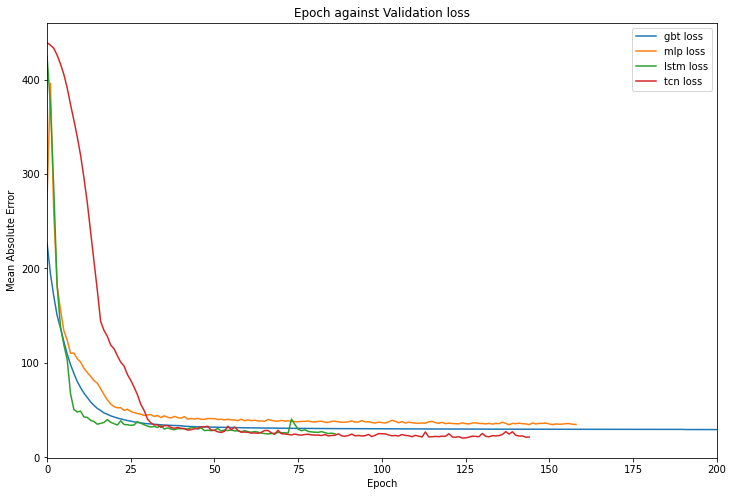

In [13]:
plt.figure(figsize=(12,8))
for model in ['gbt', 'mlp', 'lstm', 'tcn']:
    if model in ['mlp', 'lstm', 'tcn']: 
        history = history_list[model].history
        plt.plot(history['val_mean_absolute_error'], label = model + ' loss')
        
    elif model == 'gbt': 
        history = history_list[model]
        plt.plot(history['valid'], label = model + ' loss')
    plt.title('Epoch against Validation loss');
    plt.xlabel('Epoch');
    plt.ylabel('Mean Absolute Error');
    plt.xlim([0, 200])
    plt.legend();

## Model Evaluation

In [14]:
def evaluate_model(model_name, model, x_test, y_test, score_only = False):
    """
    Evaluates the model on test set. 
    Returns the predicted Y value. 
    If score only is True, return R2, MAE and MSE.
    """
    #GRADIENT BOOSTED TREE
    if 'gbt' in model_name:
        #predict
        y_pred = model.predict(x_test)  
        
        
    #MULTILAYER PERCEPTRON
    elif 'mlp' in model_name:
        x_test = tf.data.Dataset.from_tensors((x_test))
        #predict 
        y_pred = model.predict(x_test)
        
        
    #RECURRENT NETWORK
    elif 'tcn' in model_name or 'lstm' in model_name:
        batch_size = 128
        test_time_input = x_test[:, :, :-1]
        test_fixed_input = x_test[:, -1, -1].reshape(-1, 1)
        x_test = {'time_variant':test_time_input, 'time_invariant':test_fixed_input}
        d_test = tf.data.Dataset.from_tensor_slices((x_test)).batch(batch_size, drop_remainder = True)
        #predict
        y_pred = model.predict(d_test)
        #discard remainder not batched
        y_test = y_test[:len(y_pred)]
        
    if score_only: 
        #evaluate score on test set
        r2 = r2_score(y_true = y_test, y_pred = y_pred)
        mse = mean_squared_error(y_true = y_test, y_pred = y_pred)
        mae = mean_absolute_error(y_true = y_test, y_pred = y_pred)
        return r2, mae, mse
    else: 
        return y_pred

In [15]:
#for model comparison
multi_index = [np.array(['mlp']*3), np.array(['r2', 'mae', 'mse']*1)]
summary = pd.DataFrame(index = multi_index, columns = ['overall score', 'matrice_100', 'matrice_600', 'inspire', 'mavic'])

for model_name, model in test_model_list.items():
    if 'gbt' in model_name or 'mlp' in model_name:
        _, _, x_test, _, _, y_test, _, test_drones = gbt_data_split(df)
        
    elif 'lstm' in model_name or 'tcn' in model_name:
        try: 
            _, _, x_test, _, _, y_test, test_drones = rnn_data_split(df, param_list[model_name]['time_step'])
        except:
            _, _, x_test, _, _, y_test, test_drones = rnn_data_split(df, param_list2[model_name]['time_step'])
        
    all_r2, all_mae, all_mse = [], [], []
    for i in range(5):
        r2, mae, mse = evaluate_model(model_name, model[i], x_test, y_test, score_only=True)
        all_r2.append(r2)
        all_mae.append(mae)
        all_mse.append(mse)
        
    all_r2, all_mae, all_mse = np.array(all_r2), np.array(all_mae), np.array(all_mse)
    summary.loc[(model_name, 'r2'), 'overall score'] = f'{all_r2.mean():.3f} + {all_r2.std():.3f}'
    summary.loc[(model_name, 'mae'), 'overall score'] = f'{all_mae.mean():.3f} + {all_mae.std():.3f}'
    summary.loc[(model_name, 'mse'), 'overall score'] = f'{all_mse.mean():.3f} + {all_mse.std():.3f}'

    for current_drone in np.unique(test_drones):
        idx = np.where(test_drones == current_drone)
        all_r2, all_mae, all_mse = [], [], []
        for i in range(5):
            try:
                r2, mae, mse = evaluate_model(model_name, model[i], x_test.iloc[idx], y_test.iloc[idx], score_only=True)
            except:
                r2, mae, mse = evaluate_model(model_name, model[i], x_test[idx], y_test.iloc[idx], score_only=True)
            all_r2.append(r2)
            all_mae.append(mae)
            all_mse.append(mse)
        
        all_r2, all_mae, all_mse = np.array(all_r2), np.array(all_mae), np.array(all_mse)
        summary.loc[(model_name, 'r2'), current_drone] = f'{all_r2.mean():.3f} + {all_r2.std():.3f}'
        summary.loc[(model_name, 'mae'), current_drone] = f'{all_mae.mean():.3f} + {all_mae.std():.3f}'
        summary.loc[(model_name, 'mse'), current_drone] = f'{all_mse.mean():.3f} + {all_mse.std():.3f}'

In [16]:
summary

overall score         matrice_100          matrice_600  \
mlp  r2        0.945 + 0.003       0.955 + 0.004       -0.013 + 0.015   
     mae      35.722 + 1.386      30.413 + 1.555       68.482 + 1.435   
     mse  5899.938 + 285.945  2523.856 + 235.388  22338.084 + 339.886   
gbt  r2        0.968 + 0.000       0.970 + 0.000        0.437 + 0.000   
     mae      29.117 + 0.000      22.797 + 0.000       58.029 + 0.000   
     mse    3412.569 + 0.000    1666.830 + 0.000    12415.093 + 0.000   
lstm r2        0.977 + 0.003       0.972 + 0.005        0.896 + 0.040   
     mae      23.990 + 2.299      22.238 + 2.077       28.747 + 5.074   
     mse  2428.088 + 356.371  1540.989 + 270.259  2741.445 + 1058.123   
tcn  r2        0.978 + 0.002       0.963 + 0.007        0.918 + 0.008   
     mae      24.944 + 2.315      26.050 + 3.445       25.358 + 1.944   
     mse  2310.626 + 263.082  2064.127 + 390.296   2156.088 + 221.927   

                       inspire              mavic  
mlp  r2          0.696 + 0.053      0.524 + 0.268  
     mae        38.603 + 3.374     15.072 + 1.954  
     mse    5123.889 + 898.470  764.176 + 429.269  
gbt  r2          0.878 + 0.000      0.499 + 0.000  
     mae        30.342 + 0.000     20.000 + 0.000  
     mse      2050.969 + 0.000    803.061 + 0.000  
lstm r2          0.371 + 0.078      0.900 + 0.039  
     mae        47.974 + 3.576      5.190 + 0.888  
     mse  10155.152 + 1265.473   162.192 + 63.138  
tcn  r2          0.644 + 0.040      0.530 + 0.282  
     mae        40.029 + 2.955      7.099 + 2.365  
     mse    5743.750 + 637.638  763.566 + 458.607

## Prediction Step

In [17]:
def get_interpolation_range(x_train, train_drones):
    """
    Returns the range of values of variables used in the training set
    """
    range_dictionary = {}
    for drone in np.unique(train_drones):
        idx = np.where(train_drones == drone)
        temp = x_train.iloc[idx]
        variable_dict = {}
        for variable in temp.columns:
            min_val = round(temp.loc[:, variable].min(),2)
            max_val = round(temp.loc[:, variable].max(),2)
            variable_dict[variable] = (min_val, max_val)
        range_dictionary[drone] = variable_dict
    return range_dictionary

def check_interpolation(dataframe, model_name=model_name):
    """
    For each row, check all variables if data is within +-0.01
    Return the battery power for labelling extrapolation
    """
    drone = dataframe['drone_type']
    for variable, rng in range_dictionary[drone].items():
        if dataframe[variable] < rng[0]-0.01 or dataframe[variable] > rng[1]+0.01: return dataframe['battery_power']

In [18]:
def plot_prediction(dataframe, flightno, model_name, min_t=0, max_t=-1, quantile = False, extrapolation = False, ax = None):
    """
    This function plots parameter against time for given flight number.
    """
    style = {'gbt': '-', 'mlp': '-', 'lstm': '-' ,'tcn': '-'}
    color = {'gbt': 'tab:blue', 'mlp': 'tab:orange', 'lstm': 'tab:green' ,'tcn': 'tab:purple'}
    
    for flno in flightno:
        plotdata = dataframe.loc[dataframe['flight'] == flno].copy()
        t = plotdata['time'] - float(plotdata['time'].head(n=1))
        drone_name = plotdata['drone_type'].iloc[0]
        y = plotdata['battery_power']
        #ground truth
        ax.plot(t[min_t:max_t], y[min_t:max_t],
                label = 'ground truth', linestyle = '-', linewidth=2.5, color = 'k')
        
        #flight statistics
        #print(f'{drone_name} flight {flno} true mean: {float(y.mean()):.2f}')
        #print(f'{drone_name} flight {flno} true std: {float(y.std()):.2f}')
        
        #plot quantile
        if quantile:
            for var in model_name:
                y1 = plotdata[var+'_0.1']
                y2 = plotdata[var+'_0.5']
                y3 = plotdata[var+'_0.9']
                ax.fill_between(t[min_t:max_t], y1[min_t:max_t], y3[min_t:max_t],
                                alpha=0.2, interpolate = True, color = color[var])
                ax.plot(t[min_t:max_t], y2[min_t:max_t], style[var],
                         label = var, linewidth=2.5, color=color[var])
        #plot prediction
        else:          
            for var in model_name:
                y = plotdata[var]
                ax.plot(t[min_t:max_t], y[min_t:max_t], style[var], 
                         label = var, linewidth=2.5, color=color[var])
                
                #prediction statistics
                #print(f'{drone_name} flight {flno} {var} Predicted mean: {float(y.mean()):.2f}')
                #print(f'{drone_name} flight {flno} {var} Predicted std: {float(y.std()):.2f}')
                
        #check extrapolation
        if extrapolation:
            y = plotdata['extrapolated']
            if ~np.isnan(y.max()): ax.scatter(t[min_t:max_t], y[min_t:max_t], label = 'extrapolated', marker = 'x', s = 150, color = 'r')
                        
            
    ax.set_ylabel('Battery Power (W)')
    ax.set_xlabel('Time (s)')
    ax.legend()

In [19]:
#code from https://gist.github.com/phobson/41b41bdd157a2bcf6e14
def speed_labels(bins, units):   
    labels = []
    for left, right in zip(bins[:-1], bins[1:]):
        if left == bins[0]:
            labels.append('ground'.format(right))
        elif np.isinf(right):
            labels.append('>{} {}'.format(left, units))
        else:
            labels.append('{} - {} {}'.format(left, right, units))
    return list(labels)

def _convert_dir(directions, N=None):
    if N is None:
        N = directions.shape[0]
    barDir = directions * np.pi/180. - np.pi/N
    barWidth = 2 * np.pi / N
    return barDir, barWidth

def create_windrose(dataframe, flightno = None, by_flight = False, min_t=0, max_t=-1):
    if by_flight:
        temp = dataframe[dataframe['flight']==flightno].copy()
    else:
        temp = dataframe.copy()
        
    total_count = temp.shape[0]
    calm_count = temp.query("wind_speed == 0").shape[0]
    spd_bins = [-1, 0, 5, 10, 15, np.inf]
    spd_labels = speed_labels(spd_bins, units='m/s')
    dir_bins = np.arange(-7.5, 367.5, 15)
    dir_labels = (dir_bins[:-1] + dir_bins[1:]) / 2
    
    rose = (
    temp.assign(wind_speed_bins=lambda temp2:
            pd.cut(temp2['wind_speed'], bins=spd_bins, labels=spd_labels, right=True)
         )
        .assign(wind_angle_bins=lambda temp2:
            pd.cut(temp2['wind_angle'], bins=dir_bins, labels=dir_labels, right=False)
         )
        .replace({'wind_angle_bins': {360: 0}})
        .groupby(by=['wind_speed_bins', 'wind_angle_bins'])
        .size()
        .unstack(level='wind_speed_bins')
        .fillna(0)
        .assign(ground=lambda temp2: calm_count / temp.shape[0])
        .sort_index(axis=1)
        .applymap(lambda x: x/total_count*100))
    
    wind_dirs = np.arange(0., 360., 15)
    for i in wind_dirs:
        if i not in rose.index:
            rose = rose.reindex(rose.index.values.tolist()+[i])
    rose = rose.sort_index().fillna(0)
    return rose

def plot_windrose(rosedata, title, palette=None):
    if palette is None:
        palette = sb.color_palette('inferno', n_colors=rosedata.shape[1])

    wind_dirs = np.arange(0., 360., 15)
    bar_dir, bar_width = _convert_dir(wind_dirs)

    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(polar=True))
    ax.set_theta_direction('clockwise')
    ax.set_theta_zero_location('N')
    
    for n, (c1, c2) in enumerate(zip(rosedata.columns[:-1], rosedata.columns[1:])):
        if n == 0:
            # first column only
            ax.bar(bar_dir, rosedata[c1], 
                   width=bar_width,
                   color=palette[0],
                   edgecolor='none',
                   label=c1,
                   linewidth=0)
            
        # all other columns
        ax.bar(bar_dir, rosedata[c2].values, 
               width=bar_width, 
               bottom=rosedata.cumsum(axis=1)[c1].values,
               color=palette[n+1],
               edgecolor='none',
               label=c2,
               linewidth=0)
    #format
    leg = ax.legend(loc=(0, 0.95), ncol=1)
    ax.set_title(title+'\n')
    #angle
    ticks_loc = ax.get_xticks().tolist()
    ax.set_xticks(ticks_loc)
    ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']);
    #percentage
    ticks_loc = ax.get_yticks()
    ax.set_yticks(ticks_loc)
    ax.set_yticklabels([f'{x:.1f}%' for x in ticks_loc]);
    
    return fig

## Results

In [20]:
plot_df = df.copy()

#label extrapolation
x_train, _, _, _, _, _, train_drones, _ = gbt_data_split(plot_df)
range_dictionary = get_interpolation_range(x_train, train_drones)
plot_df['extrapolated'] = plot_df.apply(check_interpolation, axis = 1)
    
for model_name, model in model_list.items():
    if 'gbt' in model_name or 'mlp' in model_name:
        x_data = plot_df[features]
    elif 'lstm' in model_name or 'tcn' in model_name:
        try: 
            x_data = rnn_data_split(plot_df, param_list[model_name]['time_step'], batch_size = 128, for_prediction = True)
        except:
            x_data = rnn_data_split(plot_df, param_list2[model_name]['time_step'], batch_size = 128, for_prediction = True)
    #predict power
    y_pred = evaluate_model(model_name, model, x_data, _, score_only=False)
    #incase of padding, equalize length
    y_pred = y_pred[:plot_df.shape[0]]
    plot_df[model_name] = y_pred

In [21]:
summary2 = pd.DataFrame.from_dict(range_dictionary, orient = 'index')
summary2

,v_N,v_E,v_D,a_N,a_E,a_D,wind_N,wind_E,total_mass
inspire,"(-0.91, 0.86)","(-1.28, 1.29)","(-4.41, 4.06)","(-0.04, 0.06)","(-0.08, 0.09)","(-1.38, -0.73)","(0.0, 0.0)","(0.0, 0.0)","(2.84, 2.84)"
matrice_100,"(-4.62, 9.04)","(-9.27, 9.97)","(-3.58, 3.58)","(-4.0, 4.41)","(-3.4, 4.48)","(-1.12, -0.85)","(-13.76, 12.4)","(-13.27, 11.03)","(3.68, 4.43)"
matrice_600,"(-9.43, 10.36)","(-11.01, 9.12)","(-4.91, 2.94)","(-0.16, 0.21)","(-0.15, 0.09)","(-1.28, -0.73)","(-6.46, 6.63)","(-6.49, 7.42)","(9.1, 9.1)"
mavic,"(-3.28, 3.96)","(-9.05, 4.58)","(-3.32, 2.97)","(-0.23, 0.14)","(-0.12, 0.12)","(-1.11, -0.76)","(-5.07, 0.0)","(-0.91, 4.83)","(0.73, 0.73)"


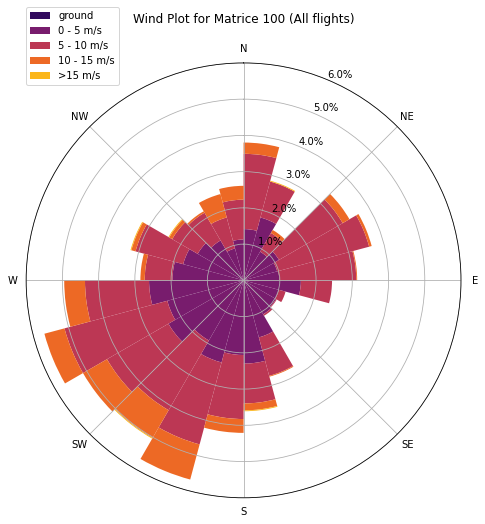

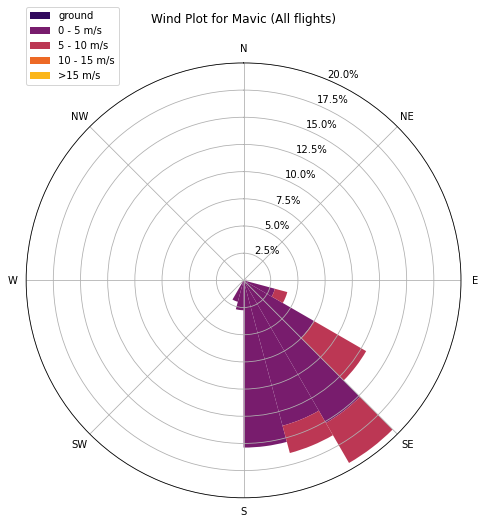

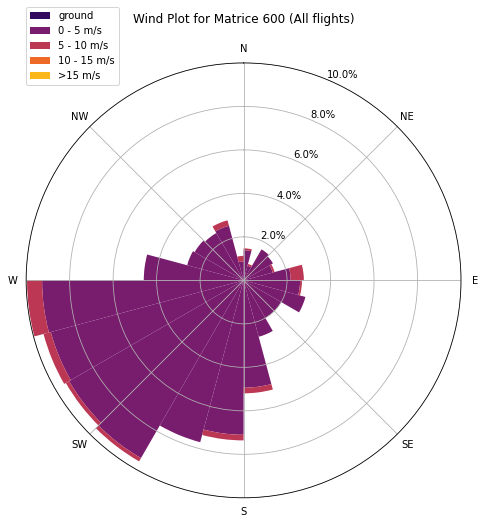

In [22]:
temp = plot_df[plot_df['drone_type']=='matrice_100'].copy()
rosedata = create_windrose(temp, 1, False)
title = 'Wind Plot for Matrice 100 (All flights)'
fig = plot_windrose(rosedata, title)

temp = plot_df[plot_df['drone_type']=='mavic'].copy()
rosedata = create_windrose(temp, 1, False)
title = 'Wind Plot for Mavic (All flights)'
fig = plot_windrose(rosedata, title)

temp = plot_df[plot_df['drone_type']=='matrice_600'].copy()
rosedata = create_windrose(temp, 1, False)
title = 'Wind Plot for Matrice 600 (All flights)'
fig = plot_windrose(rosedata, title)

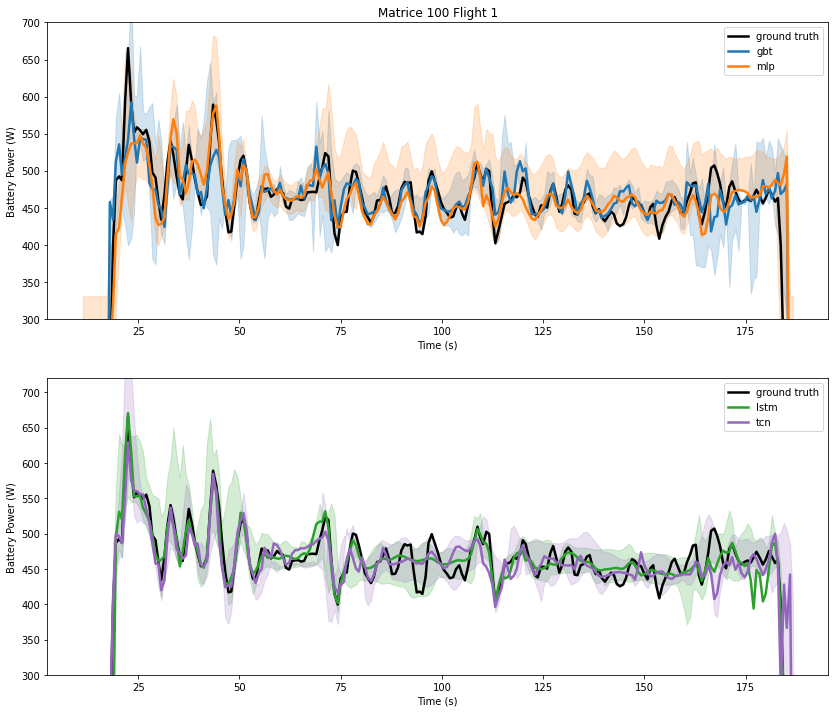

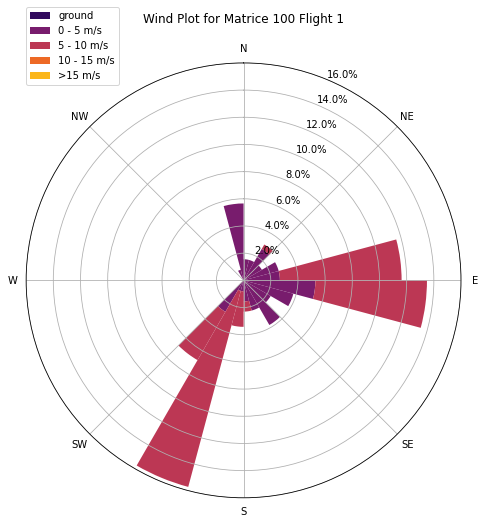

In [23]:
fig, ax = plt.subplots(2, figsize=(14,12));
plot_prediction(plot_df, [1], ['gbt', 'mlp'], min_t=15, max_t=250, quantile = True, extrapolation = True, ax=ax[0])
ax[0].set_ylim([300, 700]);
ax[0].set_title('Matrice 100 Flight 1')
plot_prediction(plot_df, [1], ['lstm', 'tcn'], min_t=15, max_t=250, quantile = True, extrapolation = True, ax=ax[1])
ax[1].set_ylim([300, 720]);

rosedata = create_windrose(plot_df, 1, True)
title = 'Wind Plot for Matrice 100 Flight 1'
fig2 = plot_windrose(rosedata, title)

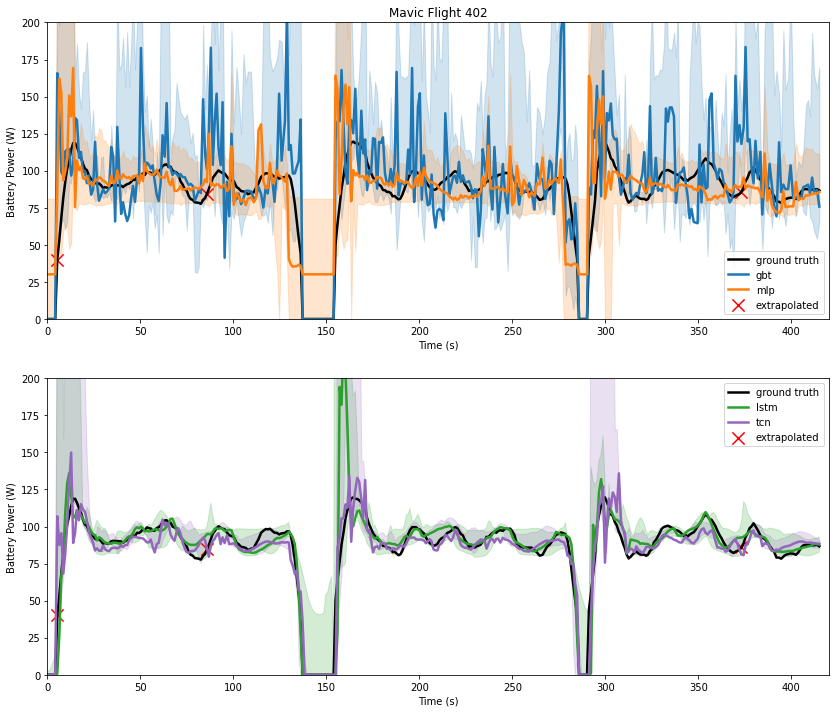

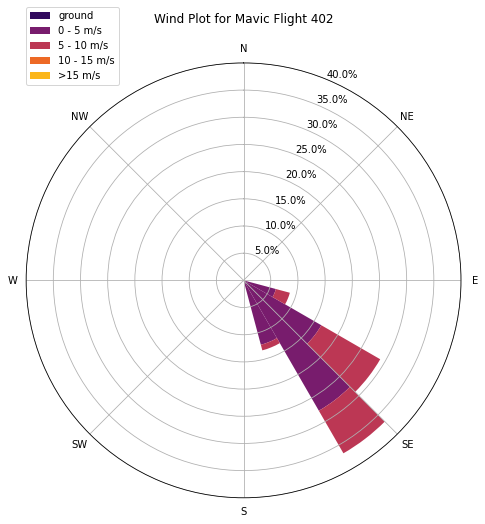

In [24]:
fig, ax = plt.subplots(2, figsize=(14,12));
plot_prediction(plot_df, [402], ['gbt', 'mlp'], min_t=0, max_t=-1, quantile = True, extrapolation = True, ax=ax[0])
ax[0].set_ylim([0, 200]);
ax[0].set_xlim([0, 420]);
ax[0].set_title('Mavic Flight 402')
plot_prediction(plot_df, [402], ['lstm', 'tcn'], min_t=0, max_t=-1, quantile = True, extrapolation = True, ax=ax[1])
ax[1].set_ylim([0, 200]);
ax[1].set_xlim([0, 420]);

rosedata = create_windrose(plot_df, 402, True)
title = 'Wind Plot for Mavic Flight 402'
fig2 = plot_windrose(rosedata, title)

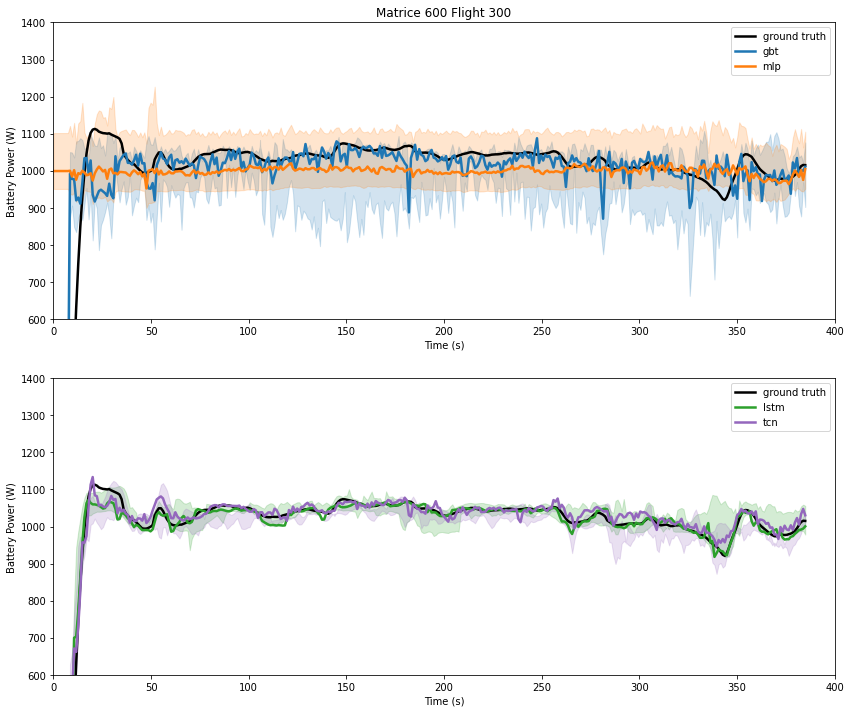

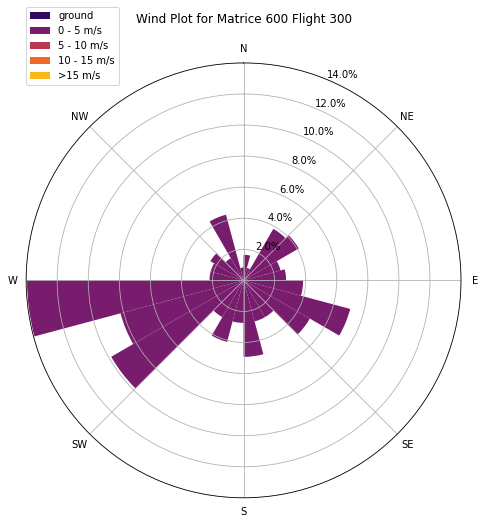

In [25]:
fig, ax = plt.subplots(2, figsize=(14,12));
plot_prediction(plot_df, [300], ['gbt', 'mlp'], min_t=0, max_t=-1, quantile = True, extrapolation = True, ax=ax[0])
ax[0].set_ylim([600, 1400]);
ax[0].set_xlim([0, 400]);
ax[0].set_title('Matrice 600 Flight 300')
plot_prediction(plot_df, [300], ['lstm', 'tcn'], min_t=0, max_t=-1, quantile = True, extrapolation = True, ax=ax[1])
ax[1].set_ylim([600, 1400]);
ax[1].set_xlim([0, 400]);

rosedata = create_windrose(plot_df, 300, True)
title = 'Wind Plot for Matrice 600 Flight 300'
fig2 = plot_windrose(rosedata, title)

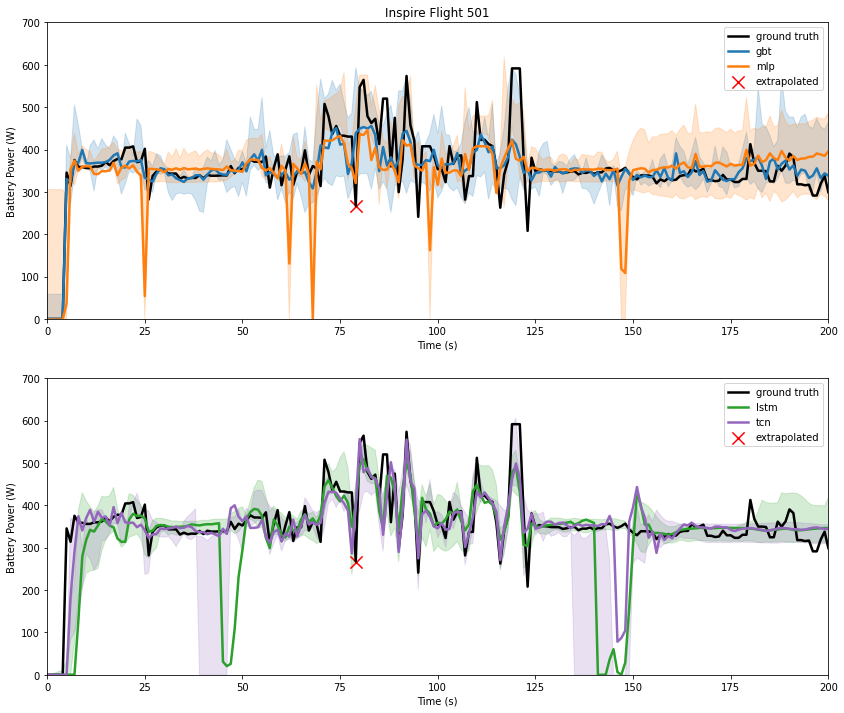

In [26]:
fig, ax = plt.subplots(2, figsize=(14,12));
plot_prediction(plot_df, [501], ['gbt', 'mlp'], min_t=0, max_t=-1, quantile = True, extrapolation = True, ax=ax[0])
ax[0].set_ylim([0, 700]);
ax[0].set_xlim([0, 200]);
ax[0].set_title('Inspire Flight 501')
plot_prediction(plot_df, [501], ['lstm', 'tcn'], min_t=0, max_t=-1, quantile = True, extrapolation = True, ax=ax[1])
ax[1].set_ylim([0, 700]);
ax[1].set_xlim([0, 200]);

## Error Analysis

The residual error is calculated as $y_{i}-\hat{y_{i}}$. In ordinary least squares, the deleted studentized residual is calculated using $t_{i} = \frac{(y_{i}-\hat{y_{i}})^{2}}{\hat\sigma\sqrt{1-h_{ii}}}$ where $\hat\sigma=\frac{1}{n-m-1}\sum{(y_{j}-\hat{y}_{j})^{2}}$ is the standard deviation estimate of error, $n$ is number of samples, $m$ is number of parameters and $h_{ii}$ is the leverage. 

However, non-linear models like GBT or NN can be considered non-parameteric because of the large number of parameters. Therefore, semistudentized residuals can be calculated as $t_{i} = \frac{(y_{i}-\hat{y_{i}})^{2}}{\sqrt{MSE}}$. To test for outliers, the distribution of the semistudentized residuals $t_{i}(1-\frac{\alpha}{2})$ was plotted for two-tailed test using 0.05 significance level. 

References: [psu.edu](https://online.stat.psu.edu/stat462/node/247/) and [purdue.edu](https://www.stat.purdue.edu/~boli/stat512/lectures/topic5.pdf)

In [27]:
def plot_residual(dataframe, model_name, residual_name, critical_value, ax=None):
    """
    Returns the residual plot of all data for a model
    """
    temp = dataframe.copy()
    max_val = np.max(temp['battery_power'])
    sb.scatterplot(data=dataframe, x='battery_power', y=model_name+'_'+residual_name, ax=ax, hue='drone_type', s=20, palette="tab10")
    ax.hlines(y=0, xmin=0, xmax=max_val, linewidth=2, linestyle = '--', color='k')
    ax.hlines(y=critical_value, xmin=0, xmax=max_val, linewidth=2, linestyle = '-', color='k')
    ax.hlines(y=-critical_value, xmin=0, xmax=max_val, linewidth=2, linestyle = '-', color='k', label=f'critical value =  {critical_value:.2f}')
    ax.set_title('Residual Plot for ' + model_name)
    ax.set_xlabel('Predicted Power');
    ax.set_ylabel(residual_name);
    ax.legend()

In [28]:
def plot_accumulated_error(dataframe, model_name, t_min=0, t_max=-1,ax=None):
    """
    Returns the accumulated error for a model with time scale normalized.
    """
    color = {'matrice_100': 'tab:blue', 'matrice_600': 'tab:orange', 'inspire': 'tab:green' ,'mavic': 'tab:purple'}
    style = {'matrice_100': '--', 'matrice_600': '-', 'inspire': ':' ,'mavic': '-.'}
    
    all_drone = []
    for i, flno in enumerate(np.unique(dataframe['flight'])):
        temp = plot_df[dataframe['flight']==flno].copy()
        drone = temp['drone_type'].head(n=1).values[0]
        y = temp[model_name+'_Accumulated Residual'][t_min: t_max] 
        t = np.linspace(0., 100., len(y))

        #normalized
        #t = (temp['time'] - float(temp['time'].head(n=1)))[t_min:t_max]
        #y = y / y.tail(n=1).values
        if drone not in all_drone: 
            ax.plot(t, y, style[drone], color = color[drone], label = drone, linewidth = 2)
            all_drone.append(drone)
        else: ax.plot(t, y, style[drone], color = color[drone], linewidth = 2)
    ax.set_title('Time Plot of Residual for ' + model_name)
    ax.set_xlabel('Percentage of Flight Time (%)');
    ax.set_ylabel('Cumulative Absolute Residual');
    ax.legend()

In [29]:
critical_list = {}

for model_name in model_list.keys():
    #residual
    plot_df[model_name+'_Residual'] = plot_df['battery_power'] - plot_df[model_name]
    #studentized residual
    plot_df[model_name+'_Studentized Residual'] = plot_df[model_name+'_Residual'] / np.sqrt(mean_squared_error(y_true=plot_df['battery_power'], y_pred = plot_df[model_name]))
    #z-score from normal distribution
    z_score = stats.norm.ppf(1 - 0.05/2)
    sample_z_score = stats.zscore(plot_df[model_name+'_Studentized Residual'])
    idx = np.where(sample_z_score >= z_score)
    critical_value = np.sort(plot_df[model_name+'_Studentized Residual'].iloc[idx]).min()
    critical_list[model_name] = critical_value

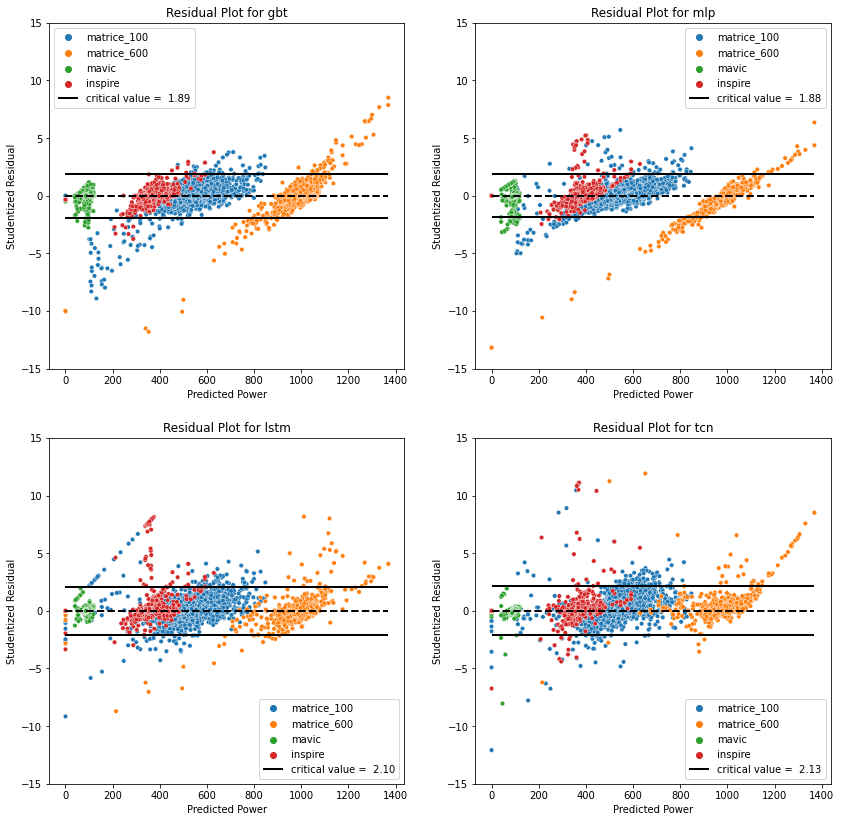

In [30]:
fig, axes = plt.subplots(2,2, figsize=(14,14));
for model_name, ax in zip(['gbt', 'mlp', 'lstm', 'tcn'], axes.flatten()):
    plot_residual(plot_df, model_name, 'Studentized Residual', critical_list[model_name], ax=ax)
    ax.set_ylim([-15,15])

In [31]:
for flno in np.unique(plot_df['flight']):
    for model_name in ['gbt', 'mlp', 'lstm', 'tcn']:
        temp = plot_df[plot_df['flight']==flno].copy()
        accumulated_error = abs(temp[model_name+'_Residual']).cumsum()
        plot_df.loc[temp.index, model_name+'_Accumulated Residual'] = accumulated_error

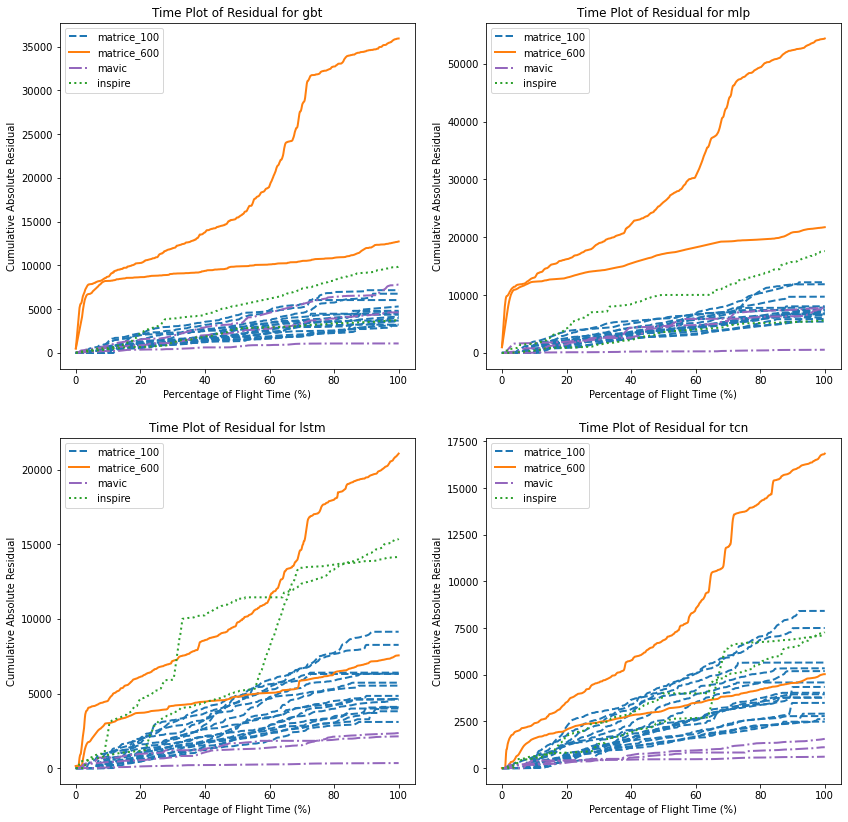

In [32]:
fig, axes = plt.subplots(2,2, figsize=(14,14));
for model_name, ax in zip(['gbt', 'mlp', 'lstm', 'tcn'], axes.flatten()):
    plot_accumulated_error(plot_df, model_name, ax=ax)

## Energy Results

In [33]:
def label_flight_mode(dataframe):
    """
    This function takes each row of the dataframe as input and returns 
    the flight mode based on the change in altitude. A tolerance 
    of 0.5 meters is used.
    """
    if dataframe['diff_alt'] > 0.5:
        return 'climb'
    elif dataframe['diff_alt'] < -0.5: 
        return 'descend'
    else:
        return 'forward'
    
def plot_seg(dataframe, flightno, ax):
    for flno in flightno:
        temp = dataframe[dataframe['flight']==flno].copy()
        sb.scatterplot(data = temp, x='time', y='alt', hue='mode', ax=ax)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Altitude (m)')
    
#code from https://github.com/castacks/cvar-energy-risk-deep-model/blob/master/evaluation.py
def calc_energy(power, ts, cp):
    """
    power (list of float): power value at each time step
    ts (list of float): time step value
    cp (list of int): starting index of each regime + last index
    NOTE: make sure that indices are matching up for all the inputs
    Returns the energy for each regime of a flight
    """
    assert len(power) == len(ts)
    assert cp[-1] == len(power) + cp[0]-1
    
    actual_power = np.zeros(len(cp)-1)
    for idx, c in enumerate(cp[:-1]):
        actual_power[idx] = simps(power.loc[c:cp[idx+1]], x=ts.loc[c:cp[idx+1]], even='avg')
    
    return actual_power

def get_change_point(dataframe):
    cp, cpmode = [], []
    #first index
    first_idx = dataframe.head(n=1).index.values[0]
    cp.append(first_idx)
    #last index
    last_idx = dataframe.tail(n=1).index.values[0]
    #loop to find all change points
    ptr = first_idx
    current = dataframe.loc[ptr]['mode']
    cpmode.append(current)
    while True:
        if ptr == last_idx: break
        ptr += 1
        new = dataframe.loc[ptr]['mode']
        if new != current:
            cp.append(ptr)
            cpmode.append(new)
            current = new
    cp.append(last_idx)
    return cp, cpmode

In [34]:
multi_index = [np.array(['matrice_100']*5), np.array(['flight 1']*5), np.array(['true', 'gbt', 'mlp', 'lstm', 'tcn'])]
summary4 = pd.DataFrame(index = multi_index, columns = ['climb', 'forward', 'descend', 'flight total'])
summary4.index.names = ['Drone','Flight','Model']

energy_df = plot_df.copy()
energy_df.index = energy_df.index+1
flight_list = np.unique(energy_df['flight'])

#calculate change in altitude (smooth by 5 time step)
for flno in flight_list:
    temp = energy_df[energy_df['flight']==flno]
    diff_alt = temp['alt'].diff(periods=5).fillna(0)
    energy_df.loc[temp.index, 'diff_alt'] = diff_alt
    
#apply flight mode label
energy_df['mode'] = energy_df.apply(label_flight_mode, axis = 1)

change_points = []
change_points_mode = []
#get change points when flight mode changes
for flno in flight_list:
    temp = energy_df[energy_df['flight']==flno]
    cp, cpmode = get_change_point(temp)
    change_points.append(cp)
    change_points_mode.append(cpmode)
    
#calculate energy for each mode
for i, flno in enumerate(flight_list):
    temp = energy_df[energy_df['flight']==flno]
    drone = temp['drone_type'].head(n=1).values[0]
    for model_name in ['true', 'gbt', 'mlp', 'lstm', 'tcn']:
        if model_name == 'true':       
            power = temp['battery_power']
        else:
            power = temp[model_name]
        ts = temp['time']
        cp = change_points[i]
        current_mode = change_points_mode[i]
        #calculate energy
        energy = calc_energy(power.loc[cp[0]:cp[-1]], ts.loc[cp[0]:cp[-1]], cp)
        #aggregate
        temp2 = pd.DataFrame(list(zip(current_mode, energy)),columns =['mode', 'energy'])
        #save result
        summary4.loc[(drone,'flight '+str(flno), model_name), 'flight total'] = temp2['energy'].sum()
        summary4.loc[(drone,'flight '+str(flno), model_name), 'climb'] = temp2.groupby(['mode']).sum()[['energy']].loc['climb'].values[0]
        summary4.loc[(drone,'flight '+str(flno), model_name), 'descend'] = temp2.groupby(['mode']).sum()[['energy']].loc['descend'].values[0]
        summary4.loc[(drone,'flight '+str(flno), model_name), 'forward'] = temp2.groupby(['mode']).sum()[['energy']].loc['forward'].values[0]

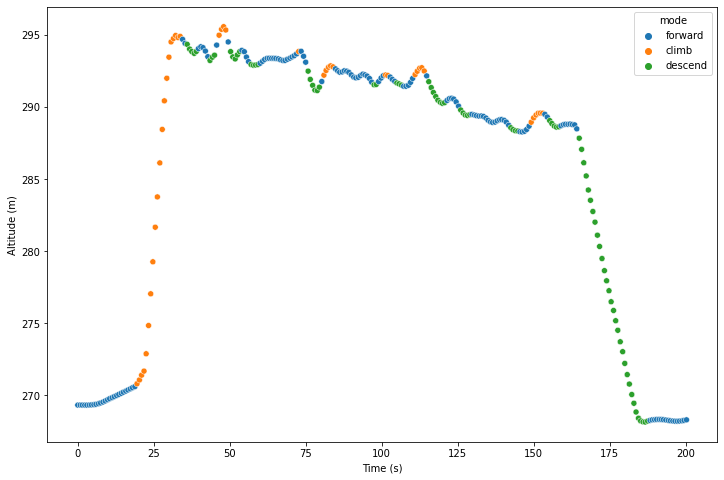

In [35]:
fig, axes = plt.subplots(1, figsize=(12,8));
plot_seg(energy_df, [1], ax=axes)

In [36]:
summary4

climb  forward  descend flight total
Drone       Flight     Model                                        
matrice_100 flight 1   true   15603.5  35631.9  26780.2      78015.5
                       gbt    15571.5  36177.6  27277.4      79026.4
                       mlp    15312.4  36514.7  27963.9        79791
                       lstm   15582.4  35220.4  25912.9      76715.6
                       tcn    15465.1  35696.4  27130.5        78292
...                               ...      ...      ...          ...
inspire     flight 501 true   74640.5  17780.8  46699.2       139120
                       gbt    73302.8  18882.8  47075.1       139261
                       mlp    70992.2  16257.4  48772.9       136022
                       lstm     72778  11543.4  45062.6       129384
                       tcn    72126.2  18188.6  47258.2       137573

[115 rows x 4 columns]

In [37]:
true_energy = summary4.groupby(level=['Model']).sum().loc['true']
predicted_energy = summary4.groupby(level=['Model']).sum()
abs(predicted_energy - true_energy) / true_energy * 100 

,climb,forward,descend,flight total
Model,,,,
gbt,0.372772,1.379637,1.074749,0.886989
lstm,1.375460,1.662922,1.423649,1.532085
mlp,0.496741,1.397235,3.028671,1.616701
tcn,2.769951,1.204949,0.965912,1.509764
true,0.000000,0.000000,0.000000,0.000000


In [38]:
energy_df2 = summary4.groupby(level=['Drone', 'Model'])
multi_index = [np.array(['matrice_100']*5+['matrice_600']*5+['mavic']*5+['inspire']*5), np.array(['gbt', 'lstm', 'mlp', 'tcn', 'true']*4)]
summary5 = pd.DataFrame(index = multi_index, columns = ['climb', 'forward', 'descend', 'flight total'])
summary5.index.names = ['Drone', 'Model']

for i in ['matrice_100', 'matrice_600', 'mavic', 'inspire']:   
    true_energy = energy_df2.sum().loc[i].loc['true']
    predicted_energy = energy_df2.sum().loc[i]
    error = abs(predicted_energy - true_energy) / true_energy * 100 
    summary5.loc[i] = error.values
summary5

climb    forward   descend flight total
Drone       Model                                            
matrice_100 gbt    0.744347    1.27307  0.862335     0.555423
            lstm   0.747158    1.73896   1.88651      1.51298
            mlp     1.85901  0.0260295   1.53453      0.04223
            tcn       2.238    1.64164   1.30079      1.68601
            true          0          0         0            0
matrice_600 gbt    0.140754   0.616109  0.935337     0.561296
            lstm    1.50143   0.287173  0.601567    0.0933689
            mlp     4.23857    2.40475   5.65292      3.12499
            tcn      4.2481    0.75086   1.31535      1.30205
            true          0          0         0            0
mavic       gbt     4.87045    23.0918   9.72439      14.1244
            lstm    2.90951    4.16316   1.40174      3.06536
            mlp     33.6416      2.825   14.4036      15.1116
            tcn     2.28899    1.66442   2.55689      2.08518
            true          0          0         0            0
inspire     gbt     0.47173    2.82125  0.618308     0.435366
            lstm      3.059    46.8942   3.39671      10.4358
            mlp      3.5719    6.68903   3.58076      1.71737
            tcn     3.35848    9.19305   1.26656      2.79223
            true          0          0         0            0

In [39]:
#calculate area under graph
energy_df2 = energy_df.copy()

for flno in flight_list:
        temp = energy_df2[energy_df['flight']==flno]
        for col in ['battery_power'] + list(model_list.keys()):
            energy = temp[col].cumsum()
            #energy = 0.5*(temp[col] + temp[col].shift(periods=-1))*(temp['time'].shift(periods=-1) - temp['time']) 
            energy_df2.loc[temp.index, col] = energy

Text(0, 0.5, 'Energy (J)')

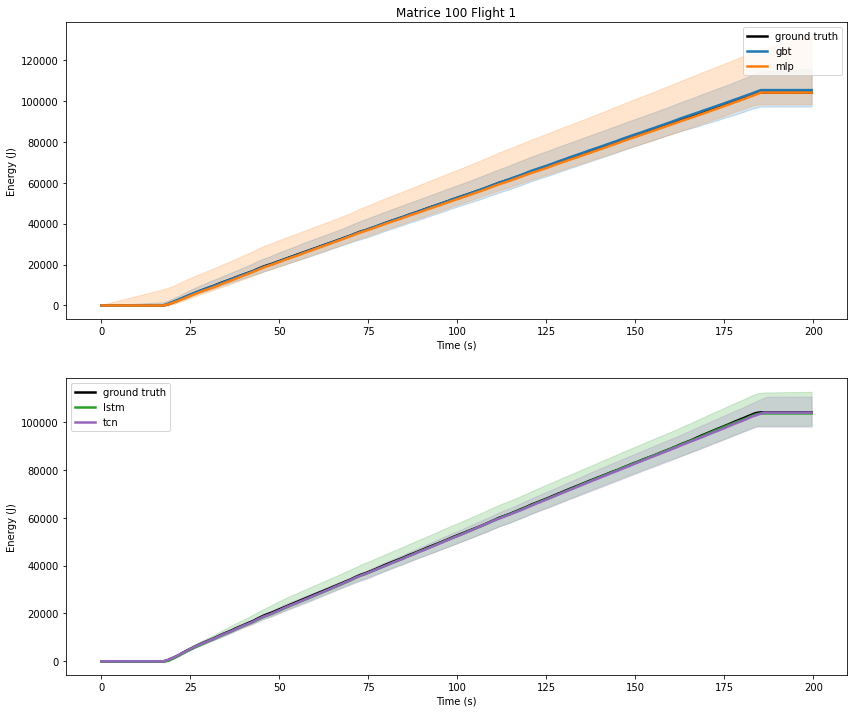

In [40]:
fig, ax = plt.subplots(2, figsize=(14,12));
plot_prediction(energy_df2, [1], ['gbt', 'mlp'], min_t=0, max_t=-1, quantile = True, extrapolation = False, ax=ax[0])
ax[0].set_ylabel('Energy (J)')
ax[0].set_title('Matrice 100 Flight 1')
plot_prediction(energy_df2, [1], ['lstm', 'tcn'], min_t=0, max_t=-1, quantile = True, extrapolation = False, ax=ax[1])
ax[1].set_ylabel('Energy (J)')

Text(0, 0.5, 'Energy (J)')

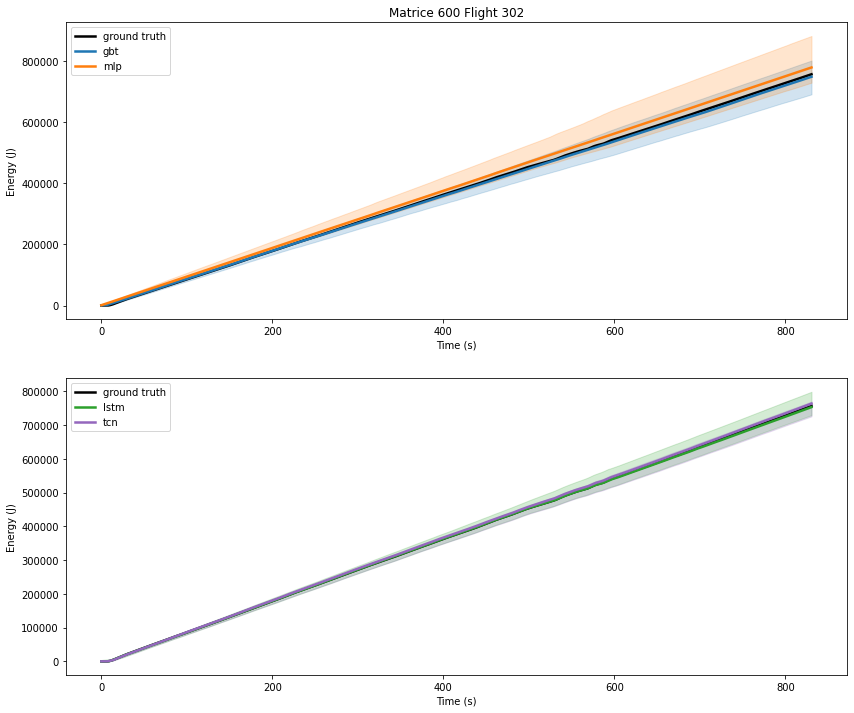

In [41]:
fig, ax = plt.subplots(2, figsize=(14,12));
plot_prediction(energy_df2, [301], ['gbt', 'mlp'], min_t=0, max_t=-1, quantile = True, extrapolation = False, ax=ax[0])
ax[0].set_ylabel('Energy (J)')
ax[0].set_title('Matrice 600 Flight 302')
plot_prediction(energy_df2, [301], ['lstm', 'tcn'], min_t=0, max_t=-1, quantile = True, extrapolation = False, ax=ax[1])
ax[1].set_ylabel('Energy (J)')

Text(0, 0.5, 'Energy (J)')

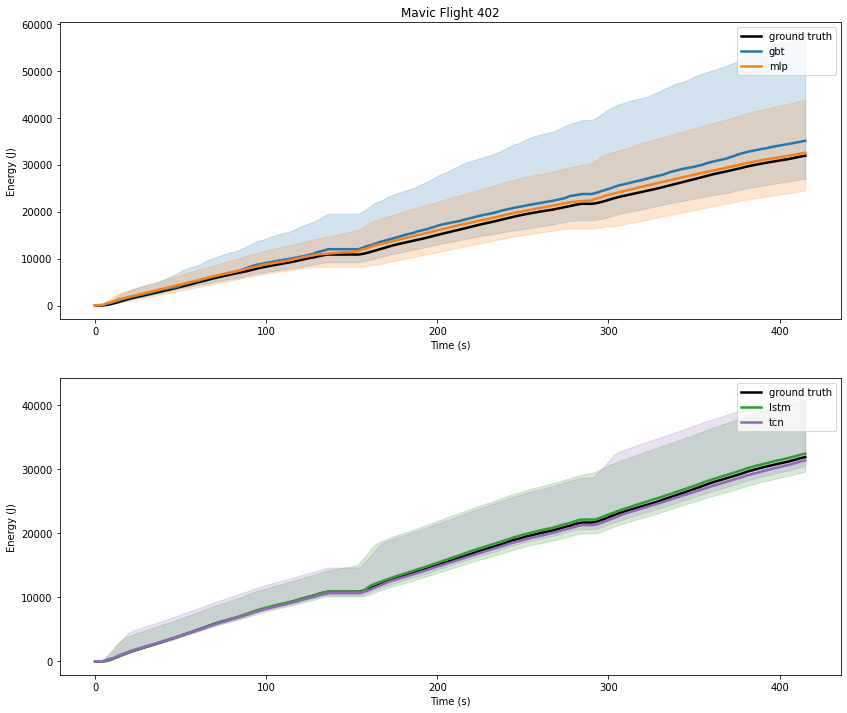

In [42]:
fig, ax = plt.subplots(2, figsize=(14,12));
plot_prediction(energy_df2, [402], ['gbt', 'mlp'], min_t=0, max_t=-1, quantile = True, extrapolation = False, ax=ax[0])
ax[0].set_ylabel('Energy (J)')
ax[0].set_title('Mavic Flight 402')
plot_prediction(energy_df2, [402], ['lstm', 'tcn'], min_t=0, max_t=-1, quantile = True, extrapolation = False, ax=ax[1])
ax[1].set_ylabel('Energy (J)')

Text(0, 0.5, 'Energy (J)')

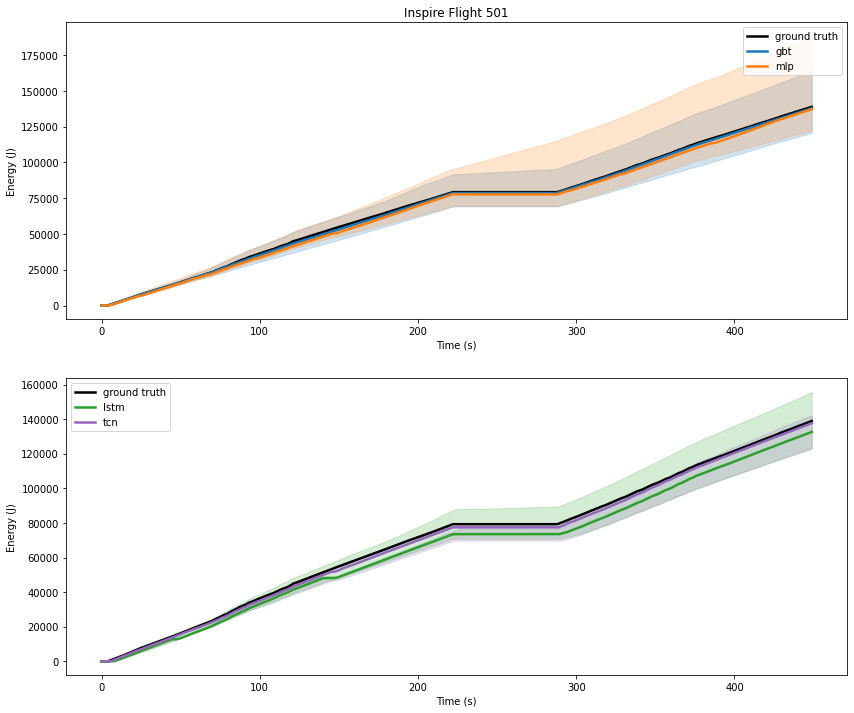

In [43]:
fig, ax = plt.subplots(2, figsize=(14,12));
plot_prediction(energy_df2, [501], ['gbt', 'mlp'], min_t=0, max_t=-1, quantile = True, extrapolation = False, ax=ax[0])
ax[0].set_ylabel('Energy (J)')
ax[0].set_title('Inspire Flight 501')
plot_prediction(energy_df2, [501], ['lstm', 'tcn'], min_t=0, max_t=-1, quantile = True, extrapolation = False, ax=ax[1])
ax[1].set_ylabel('Energy (J)')